# Deteksi Cacat pada Insulation Trafo secara Visual
## Klasifikasi Gambar Menggunakan Metode CNN

## Alfendio Alif Faudisyah - FTI UKSW

# Import Library

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import sklearn 
import itertools

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam

# Build and Recognize Dataset

## Dataset Standardization

In [27]:
# 180 x 180 x 3
img_height = 180
img_width = 180
batch_size = 32 

## Build Dataset

In [28]:
training_ds = keras.preprocessing.image_dataset_from_directory('D:/Dataset Insulation Trafo 2/Train', 
            image_size=(img_height, img_width), batch_size=batch_size)
            
testing_ds = keras.preprocessing.image_dataset_from_directory('D:/Dataset Insulation Trafo 2/Test',        
            image_size=(img_height, img_width), batch_size=batch_size)

Found 346 files belonging to 2 classes.
Found 86 files belonging to 2 classes.


## Find Class Names

In [29]:
class_names = training_ds.class_names
print("Training dataset: ",class_names)

class_names = testing_ds.class_names
print("Testing dataset: ",class_names)

Training dataset:  ['Defect', 'Normal']
Testing dataset:  ['Defect', 'Normal']


## Dataset Visualization

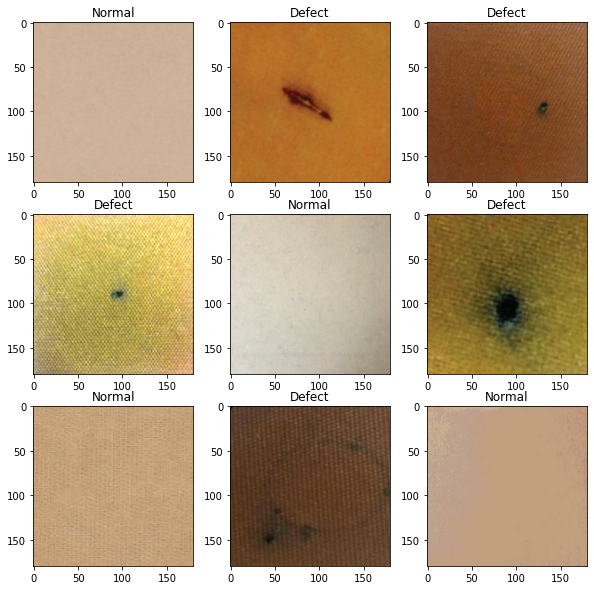

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) # convert bentuk image vektor RGB ke uint8
        plt.title(class_names[labels[i]])

## Tuning

In [31]:
# Tune dataset 
# Membuat data ada di memori
AUTOTUNE = tf.data.AUTOTUNE

train_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Build Classification Model

## Create CNN Model

In [32]:
# Class target < - 2 class
num_classes = 2

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #layers.Dropout(0.2), # dropout layer -> menghilangkan neuron yang tidak terlalu penting, mengurangi overfitting
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])  

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [34]:
# Compile Model CNN
# Compile model untuk melakukan training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# Train Model

In [35]:
# Train Model 
epochs = 10

# Simpan dalam history
history = model.fit( 
    training_ds,
    epochs=epochs
) 

Epoch 1/10
11/11 [==============================] - 2s 99ms/step - loss: 0.2976 - accuracy: 0.8468
Epoch 2/10
11/11 [==============================] - 1s 99ms/step - loss: 0.1044 - accuracy: 0.9827
Epoch 3/10
11/11 [==============================] - 2s 133ms/step - loss: 0.0496 - accuracy: 0.9884
Epoch 4/10
11/11 [==============================] - 2s 179ms/step - loss: 0.0290 - accuracy: 0.9971
Epoch 5/10
11/11 [==============================] - 2s 179ms/step - loss: 0.0165 - accuracy: 0.9971
Epoch 6/10
11/11 [==============================] - 2s 181ms/step - loss: 0.0297 - accuracy: 0.9942
Epoch 7/10
11/11 [==============================] - 2s 183ms/step - loss: 0.0355 - accuracy: 0.9913
Epoch 8/10
11/11 [==============================] - 2s 149ms/step - loss: 0.0267 - accuracy: 0.9913
Epoch 9/10
11/11 [==============================] - 1s 101ms/step - loss: 0.0873 - accuracy: 0.9855
Epoch 10/10
11/11 [==============================] - 1s 100ms/step - loss: 0.0976 - accuracy: 0.9624


## Training Visualization

Text(0.5, 1.0, 'Training Accuracy & Loss')

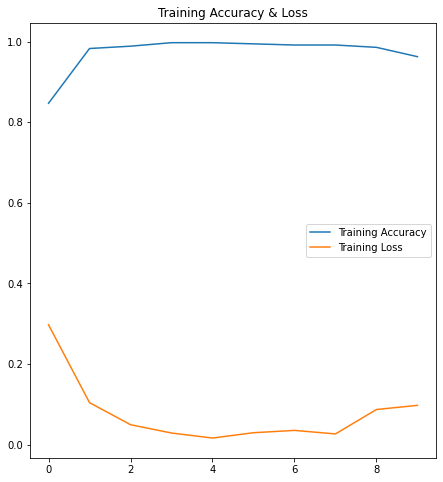

In [36]:
# Visualisasi Training Akurasi 
acc = history.history['accuracy']

# Visualisasi Training Loss
loss = history.history['loss']

# Epochs 
epochs_range = range(epochs)
plt.figure(figsize=(16, 8)) # Tampilan dalam figure

plt.subplot(1, 2, 1) # Tampilan sisi per sisi
plt.plot(epochs_range, acc, label='Training Accuracy') # Plot akurasi training
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='right') 
plt.title('Training Accuracy & Loss')

# Testing Model

## Testing Accuracy & Loss

In [37]:
test_loss, test_acc = model.evaluate(testing_ds, verbose = 1)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

3/3 [==============================] - 0s 69ms/step - loss: 0.0601 - accuracy: 0.9884

Test accuracy: 0.9883720874786377

Test loss: 0.06008617952466011


# Prediction

## Confidence Score

In [38]:
# Predict image
img = keras.preprocessing.image.load_img(
    "D:/Dataset Insulation Trafo/Test/Defect/defect  (5)_rotate_4.jpg", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 102ms/step
This image most likely belongs to Defect with a 99.98 percent confidence.


In [39]:
test_url = "https://img.machinedesign.com/files/base/ebm/machinedesign/image/2018/08/machinedesign_com_sites_machinedesign.com_files_G1_Failed_Transformer_0.png?auto=format%2Ccompress&w=320"
test_path = tf.keras.utils.get_file('', origin=test_url)

img = keras.preprocessing.image.load_img(test_path, target_size=(img_height, img_width))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model.predict(img_array)
score = tf.nn.softmax(prediction[0])

print("Gambar ini adalah {} dengan akurasi {:.2f}%.".format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 25ms/step
Gambar ini adalah Defect dengan akurasi 100.00%.


## Get the Label Names and Convert Into a NumPy Ainrray

In [40]:
class_names = np.array(class_names)

print(class_names)

['Defect' 'Normal']


## Create an Image Batch and Make Predictions

In [41]:
image_batch, label_batch = next(iter(testing_ds))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 29ms/step
['Defect' 'Normal' 'Defect' 'Defect' 'Defect' 'Defect' 'Normal' 'Normal'
 'Defect' 'Defect' 'Normal' 'Normal' 'Defect' 'Normal' 'Normal' 'Defect'
 'Normal' 'Defect' 'Normal' 'Defect' 'Normal' 'Defect' 'Defect' 'Normal'
 'Normal' 'Defect' 'Normal' 'Defect' 'Normal' 'Normal' 'Normal' 'Normal']


## Print True Labels and Predicted Indices

In [42]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1]
Predicted labels:  [0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1]


## Plot Model Predictions

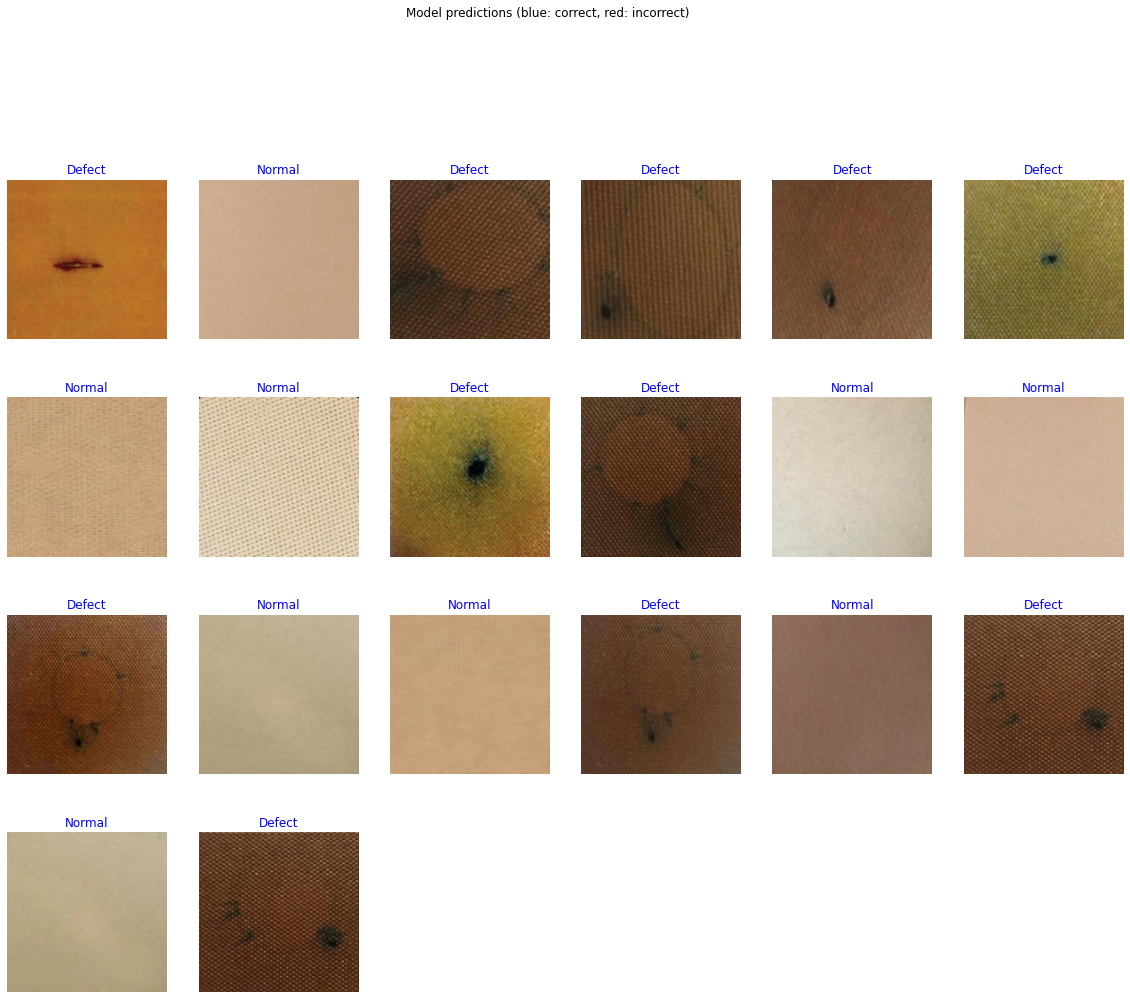

In [43]:
plt.figure(figsize=(20, 20))
for n in range(20):
    plt.subplot(5, 6, n+1)
    plt.subplots_adjust(hspace=0.)
    plt.imshow(image_batch[n].astype("uint8"))
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
    plt.suptitle("Model predictions (blue: correct, red: incorrect)")

   # print sendiri nama gambar hasil prediksi

# Model Evaluation

## Confusion Matrix

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


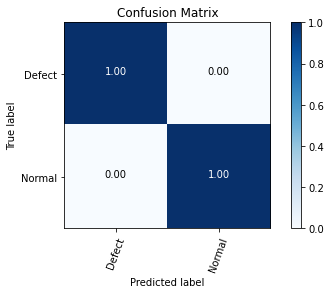

In [44]:
# confusion matrix


cm = confusion_matrix(label_batch, predicted_ids)
cm_plot_labels = ['Defect','Normal']

def plot_confusion_matrix(cm, classes,
                            normalize=True,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=70)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

- Accuracy = (TP + TN) / (TP + FP + FN + TN)
- Recall = (TP) / (TP + FN)
- Precision = (TP) / (TP + FP)
- F1 Score = (2 x (Precision x Recall)) / (Precision + Recall)

In [45]:
from sklearn.metrics import classification_report

print(classification_report(label_batch, predicted_ids, target_names=cm_plot_labels))

              precision    recall  f1-score   support

      Defect       1.00      1.00      1.00        15
      Normal       1.00      1.00      1.00        17

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



# Save Model

In [46]:
# model.save ("Save model/model_percobaan2_180")

In [47]:
# model.save ("Save model/model_percobaan2_180.h5")

In [48]:
# model_json = model.to_json()
# with open("Save model/model_percobaan2_180.json", "w") as json_file:
#     json_file.write(model_json)

# Note

> Total dataset: 432
- Training (80%) = 346
- Testing (20%) = 86

> Kelas:
- Defect (173 train, 43 test)
- Normal (173 train, 43 test)

# Alfendio Alif Faudisyah&copy;
## 2023